# Introduction to Machine Learning  

Written by Morgan Schwartz and David Van Valen.  


---

In this exercise, we are going to follow the basic workflow that is the foundation of any machine or deep learning project
1. Data wrangling
2. Model configuration and training
3. Model evaluation

Along the way, we will implement a linear classier, test a random forest classifier and explore the role of feature engineering in traditional machine learning. 

We are going to look at a collection of images of Jurkat cells published in the Broad Bioimage Collection ([BBBC048](https://bbbc.broadinstitute.org/BBBC048)). The cells were fixed and stained with PI (propidium iodide) to quantify DNA content and a MPM2 (mitotic protein monoclonal #2) antibody to identify mitotic cells. The goal is to predict the stage of the cell cycle from images like those shown below.

![](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41467-017-00623-3/MediaObjects/41467_2017_623_Fig2_HTML.jpg?as=webp)

[Eulenberg et al. (2017) Reconstructing cell cycle and disease progression using deep learning. Nature communications](https://www.nature.com/articles/s41467-017-00623-3)

<div class="alert alert-danger">
Set your python kernel to <code>01_intro_ml</code>
</div>

# Part A: The Linear Classifier

While deep learning might seem intimidating, don't worry. Its conceptual underpinnings are rooted in linear algebra and calculus - if you can perform matrix multiplication and take derivatives you can understand what is happening in a deep learning workflow. In this section, we will implement a simple linear classifier by hand and train it to predict cell cycle stages.

In [102]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
import imageio as iio
from scipy.special import softmax
import skimage
import sklearn.model_selection 
import sklearn.utils
import sklearn.metrics
import sklearn.preprocessing
import skimage.color
import skimage.transform
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import tqdm.auto

## The supervised machine learning workflow
Recall from class the conceptual workflow for a supervised machine learning project. 
- First, we create a <em>training dataset</em>, a paired collection of raw data and labels where the labels contain information about the "insight" we wish to extract from the raw data. 
- Once we have training data, we can then use it to train a <em>model</em>. The model is a mathematical black box - it takes in data and transforms it into an output. The model has some parameters that we can adjust to change how it performs this mapping. 
- Adjusting these parameters to produce outputs that we want is called training the model. To do this we need two things. First, we need a notion of what we want the output to look like. This notion is captured by a <em>loss function</em>, which compares model outputs and labels and produces a score telling us if the model did a "good" job or not on our given task. By convention, low values of the loss function's output (e.g. the loss) correspond to good performance and high values to bad performance. We also need an <em>optimization algorithm</em>, which is a set of rules for how to adjust the model parameters to reduce the loss
- Using the training data, loss function, and optimization algorithm, we can then train the model 
- Once the model is trained, we need to evaluate its performance to see how well it performs and what kinds of mistakes it makes. We can also perform this kind of monitoring during training (this is actually a standard practice).

Because this workflow defines the lifecycle of most machine learning projects, this notebook is structured to go over each of these steps while constructing a linear classifier.


## Create training data

During the initial setup of this exercise, we downloaded the data and unzipped the relevant files using the script `setup.sh`.

In [2]:
data_dir = 'data/CellCycle'
os.listdir(data_dir)

['Metaphase',
 '66.lst~',
 'Anaphase',
 'G1',
 'Telophase',
 'Prophase',
 'S',
 'G2',
 'img.lst~',
 'img.lst']

The command above should generate the following output. Order does not matter, but you should see the same files and folders. If you see something different, please check that the `setup.sh` script ran correctly.
```
['img.lst~',
 'Anaphase',
 'Prophase',
 'img.lst',
 'S',
 '66.lst~',
 'G1',
 'Metaphase',
 'G2',
 'Telophase']
 ```
 
The metadata for each file is stored in `img.lst` so we will first load this information to inform how we load the rest of the dataset.

In [3]:
# Read the csv file using pandas
df = pd.read_csv(os.path.join(data_dir, 'img.lst'), sep='\t', header=None)

# Rename columns to make the data easier to work with
df = df.rename(columns={1: 'class', 2: 'filepath'})

# Extract the channel information from the filepath column and create a new column with it
df['channel'] = df['filepath'].str.split('/',expand=True)[2].str.split('_', expand=True)[1].str.slice(2,3)

# Extract the file ID from the filepath and save in its own column
df['id'] = df['filepath'].str.split('/',expand=True)[2].str.split('_', expand=True)[0]

# Look at the first few rows in the dataframe
df.head()

,0,class,filepath,channel,id
0,19,0,./Anaphase/12432_Ch3.ome.jpg,3,12432
1,8,0,./Anaphase/12432_Ch4.ome.jpg,4,12432
2,35,0,./Anaphase/12432_Ch6.ome.jpg,6,12432
3,36,0,./Anaphase/22004_Ch3.ome.jpg,3,22004
4,1,0,./Anaphase/22004_Ch4.ome.jpg,4,22004


In [4]:
# Check the total number of unique classes in the dataset
df['class'].unique()

array([0, 4, 5, 1, 2, 6, 3])

In [110]:
class_lut = [
    'Ana',
    'Meta',
    'Pro',
    'Telo',
    'G1',
    'G2',
    'S'
]

For each `id` there are three images. One for each of the channels: phase, PI and MPM2. Let's take a look at a single image

/var/folders/bd/bn434f8n1bsdd8y0yby_fv7r0000gn/T/ipykernel_20807/1660144752.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im3 = iio.imread(os.path.join(data_dir, filepath))
/var/folders/bd/bn434f8n1bsdd8y0yby_fv7r0000gn/T/ipykernel_20807/1660144752.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im4 = iio.imread(os.path.join(data_dir, filepath))
/var/folders/bd/bn434f8n1bsdd8y0yby_fv7r0000gn/T/ipykernel_20807/1660144752.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and ma

Text(0.5, 1.0, 'MPM2')

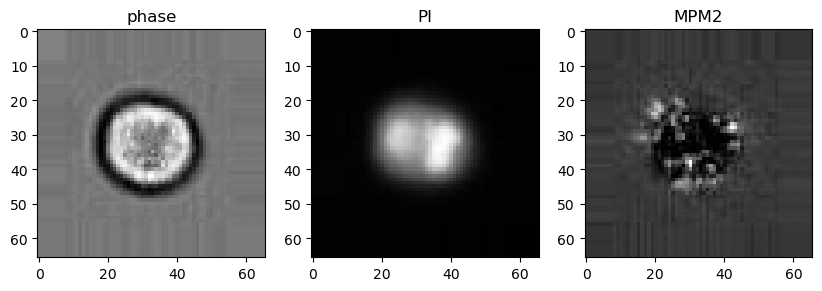

In [5]:
im_id = '12432'

# Load channel 3
filepath = df[(df['id'] == im_id) & (df['channel'] == '3')]['filepath'].values[0]
im3 = iio.imread(os.path.join(data_dir, filepath))

# Load channel 4
filepath = df[(df['id'] == im_id) & (df['channel'] == '4')]['filepath'].values[0]
im4 = iio.imread(os.path.join(data_dir, filepath))

# Load channel 6
filepath = df[(df['id'] == im_id) & (df['channel'] == '6')]['filepath'].values[0]
im6 = iio.imread(os.path.join(data_dir, filepath))

# Create a matplotlib subplot with one row and 3 columns 
# Plot each of the three images
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].imshow(im3, cmap='Greys_r')
ax[0].set_title('phase')
ax[1].imshow(im4, cmap='Greys_r')
ax[1].set_title('PI')
ax[2].imshow(im6, cmap='Greys_r')
ax[2].set_title('MPM2')

Now we can load all of the images into the dataset. We will want to load each of the three channels for each image and create an array with the shape (w, h, ch). Then we will combine all images in the dataset into a single array.

In [6]:
# Create empty lists to hold images and classes as we load them
ims = []
ys = []

# Iterate over each unique id in the dataset
for i, g in df.groupby('id'):
    im = []
    
    # Each row in the group corresponds to a different channel for a single image/id
    for _, r in g.iterrows():
        # Set the complete filepath for this image
        path = os.path.join(data_dir, r['filepath'])
        
        # Load in the data using imageio and append to a list
        im.append(iio.imread(path))
        
    # Stack a list of three images into a single 
    im = np.stack(im, axis=-1)
    ims.append(im)
    ys.append(r['class'])
    
X_data = np.stack(ims)
y_data = np.stack(ys)
print('X shape:', X_data.shape)
print('y shape:', y_data.shape)

/var/folders/bd/bn434f8n1bsdd8y0yby_fv7r0000gn/T/ipykernel_20807/260011201.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im.append(iio.imread(path))


X shape: (32266, 66, 66, 3)
y shape: (32266,)


In the previous cell, you probably observed that there are 4 dimensions rather than the 3 you might have been expecting. This is because while each image is (66, 66, 3), the full dataset has many images. The different images are stacked along the first dimension. The full size of the training images is (# images, 66, 66, 3) - the first dimension is often called the batch dimension.

Let's take a look at a sample image from each class and plot each of the three channels separately.

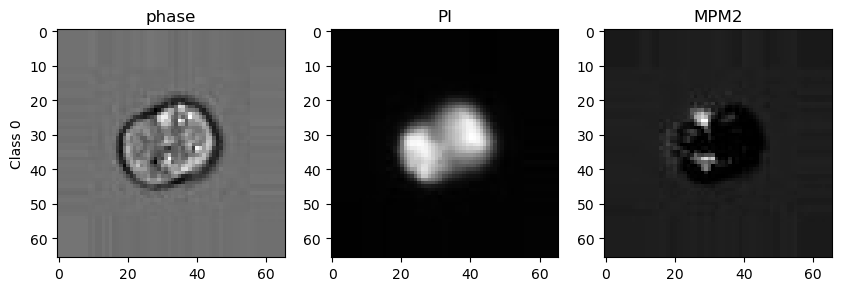

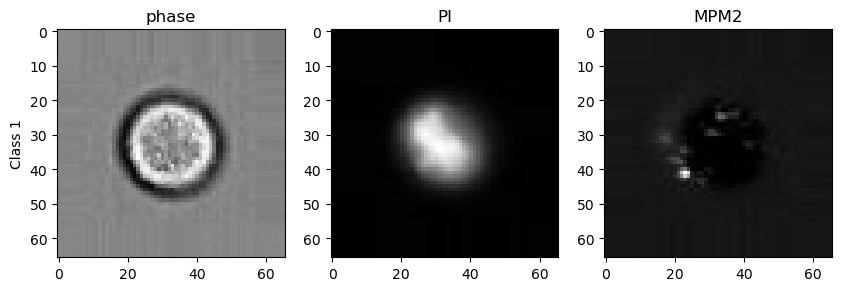

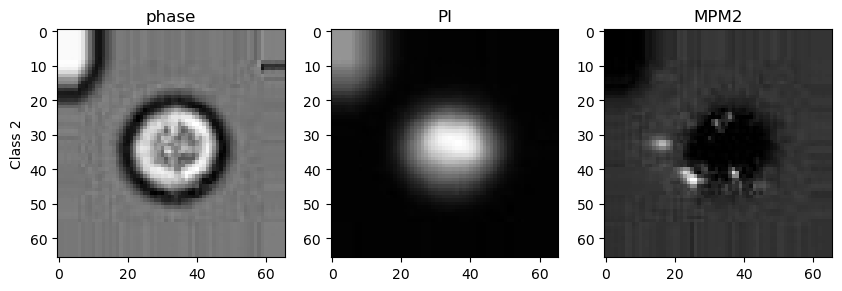

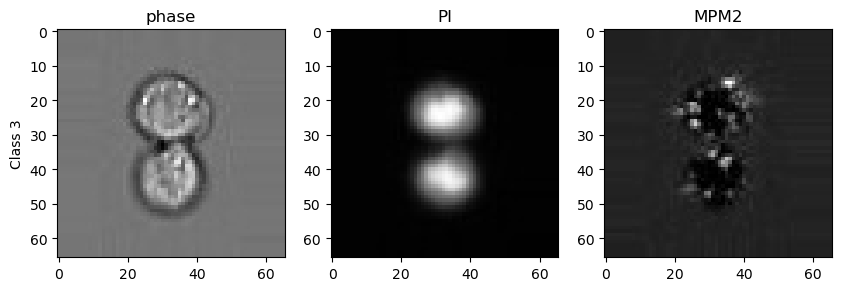

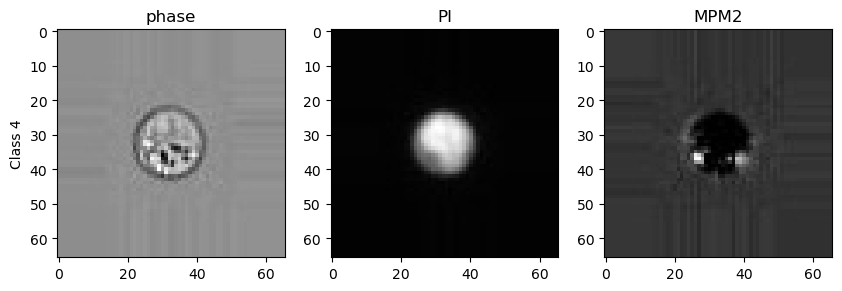

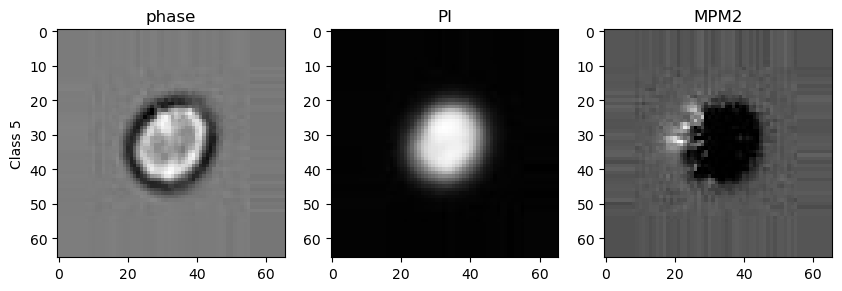

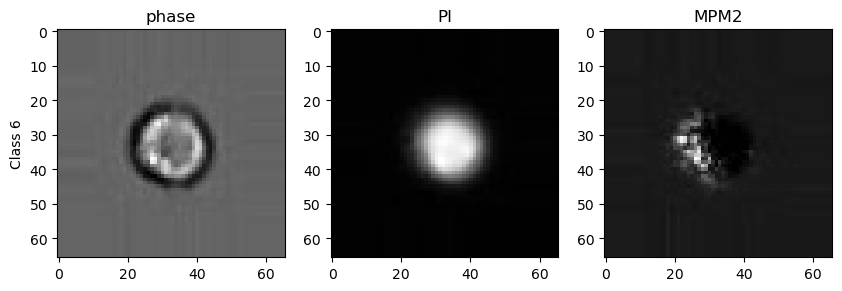

In [7]:
# Iterate over each class in the dataset
for c in np.unique(y_data):
    # Select a random index for the class of interest
    i = np.random.choice(np.where(y_data == c)[0])
    
    # Create a matplotlib subplot with one row and 3 columsn
    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    ax[0].set_ylabel(class_lut[c])
    
    # Plot each of the three channels
    for j, ch in enumerate(['phase', 'PI', 'MPM2']):
        ax[j].imshow(X_data[i,...,j], cmap='Greys_r')
        ax[j].set_title(ch)

For this exercise, we will want to flatten the training data into a vector and select a single channel to work with. We work with the phase channel first.

In [8]:
# Record the original width so that we can use this for reshaping later
image_width = X_data.shape[1]
image_width

66

In [9]:
# Flatten the images 1d vectors
X_flat = np.reshape(X_data[...,0 ], (-1, image_width * image_width))
print(X_flat.shape)

(32266, 4356)


### Checking Class Balance

<div class="alert alert-block alert-info">

#### Task 1.1
    
Let's check the balance of classes in this dataset. There are at least three ways you could do this. Pick one to try.
    
- Use matplotlib to create a histogram (`plt.hist`, [see docs](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html))
- Count the number of items in each class using `np.count_nonzero` ([see docs](https://numpy.org/doc/stable/reference/generated/numpy.count_nonzero.html)).
- Use the `Counter` object which is imported from `collections` ([see docs](https://docs.python.org/3/library/collections.html#collections.Counter))

</div>

In [10]:
##########################
######## To Do ###########
##########################

# Add your code to check class balances here
# You should end up with a count of number of items in each of the 7 classes

Class 0: 15
Class 1: 68
Class 2: 606
Class 3: 27
Class 4: 14333
Class 5: 8601
Class 6: 8616
------

Counter({4: 14333, 6: 8616, 5: 8601, 2: 606, 1: 68, 3: 27, 0: 15})
------



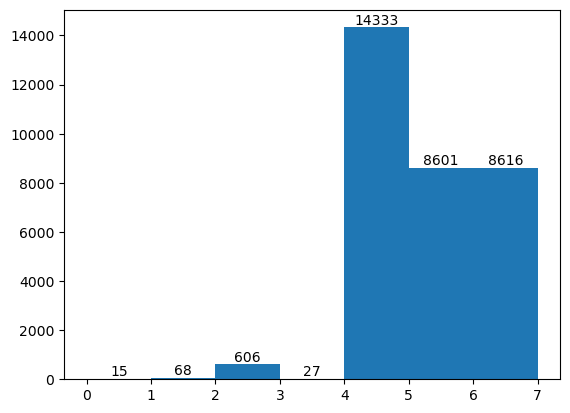

In [11]:
##########################
####### Solution #########
##########################

# Numpy option
for i in range(7):
    print('Class {}:'.format(i), np.count_nonzero(y_data == i))
    
print('------\n')

# Counter option
print(Counter(y_data))

print('------\n')
    
# Matplotlib option
counts, edges, bars = plt.hist(y_data, bins=np.arange(0,8))
_ = plt.bar_label(bars)

This dataset is highly inbalanced so we will want to correct the class balance before training.

### Split the training dataset into training and testing datasets
How do we know how well our model is doing? A common practice to evaluate models is to evaluate them on splits of the original training dataset. Splitting the data is important, because we want to see how models perform on data that was not used to train them.
- The <em>training</em> dataset used to train the model
- A held out <em>testing</em> dataset used to evaluate the final trained version of the model

While there is no hard and fast rule, 80%/20% splits are a reasonable starting point.

In [12]:
# Split the dataset into training, validation, and testing splits
seed = 10
train_size = 0.8
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X_flat, y_data, 
    train_size=train_size, 
    random_state=seed)

### Correct class imbalance

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*6DlvkNY2TlFw2Veyvb4qdQ.jpeg) 

(*Image by [Angelica Lo Duca](https://towardsdatascience.com/how-to-balance-a-dataset-in-python-36dff9d12704)*)

There are several ways to correct class imbalance. In this example, we are going to oversample underrepresented classes until we have an equal number of samples for each class. 

It's important to note that we need to correct class imbalance after generating the train/test split in our dataset. When we are oversampling, we want to prevent samples that are used in our training dataset from also appearing in our testing dataset.

<div class="alert alert-block alert-info">

#### Task 1.2

Complete the `balance_classes` function by using the `RandomOverSampler` ([docs](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html)) from [`imblearn`](https://imbalanced-learn.org/stable/index.html) to correct class balance.

</div>

In [13]:
##########################
######## To Do ###########
##########################

def balance_classes(X, y):
    """Uses RandomOverSampler to correct class imbalance
    
    Args:
        X (np.array): Array of raw data
        y (np.array): Array of class labels
        
    Returns:
        np.array: X
        np.array: y
    """
    print(f'Starting distribution: {Counter(y)}')
    
    # Add your code using RandomOverSampler to over sample minority classes
    X_res, y_res = ...
    
    print(f'Corrected distribution: {Counter(y_res)}')
    
    return X_res, y_res

In [14]:
##########################
####### Solution #########
##########################

def balance_classes(X, y):
    """Uses RandomOverSampler to correct class imbalance
    
    Args:
        X (np.array): Array of raw data
        y (np.array): Array of class labels
        
    Returns:
        np.array: X
        np.array: y
    """
    print(f'Starting distribution: {Counter(y)}')
    
    # Add your code using RandomOverSampler to over sample minority classes
    ros = RandomOverSampler()
    X_res, y_res = ros.fit_resample(X, y)
    
    print(f'Corrected distribution: {Counter(y_res)}')
    
    return X_res, y_res

In [15]:
X_train, y_train = balance_classes(X_train, y_train)
X_test, y_test = balance_classes(X_test,  y_test)
print(f'Train shape: X {X_train.shape}, y {y_train.shape}')
print(f'Test shape: X {X_test.shape}, y {y_test.shape}')

Starting distribution: Counter({4: 11493, 6: 6888, 5: 6859, 2: 484, 1: 57, 3: 20, 0: 11})
Corrected distribution: Counter({4: 11493, 5: 11493, 1: 11493, 6: 11493, 2: 11493, 3: 11493, 0: 11493})
Starting distribution: Counter({4: 2840, 5: 1742, 6: 1728, 2: 122, 1: 11, 3: 7, 0: 4})
Corrected distribution: Counter({4: 2840, 5: 2840, 6: 2840, 0: 2840, 3: 2840, 2: 2840, 1: 2840})
Train shape: X (80451, 4356), y (80451,)
Test shape: X (19880, 4356), y (19880,)


### One-hot encoding

Currently, our data have labels that range from 0 to 6. While we know that each of these 7 classes is comparable, this encoding implies that some classes have more weight than others. Alternatively, we want to use a binary encoding so that all classes are seen as equivalent by the model. 

Instead of representing each label with a number from 0 to 6, we will use an array of length 7 where each position in the array is a binary value encoding the class. 

For example, `5` is encoded as `[0, 0, 0, 0, 1, 0, 0]`

<div class="alert alert-block alert-info">

#### Task 1.3

In order to transform our data from integer to one-hot encoding, we will use `sklearn's` `LabelBinarizer` ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html#sklearn.preprocessing.LabelBinarizer)). Take a look at the documentation to learn how to initialize and fit the `LabelBinarizer` and add your code below.
</div>

In [16]:
##########################
######## To Do ###########
##########################

# Initialize and fit the LabelBinarizer
lb = ...

In [17]:
##########################
####### Solution #########
##########################

# Initialize and fit the LabelBinarizer
lb = sklearn.preprocessing.LabelBinarizer()
lb.fit(y_train)

LabelBinarizer()

In [18]:
lb.classes_

array([0, 1, 2, 3, 4, 5, 6])

Run the following cell to check that you set up the `LabelBinarizer` correctly.

In [19]:
# Check that the detected classes are correct
print(lb.classes_, '\n')
assert np.all(lb.classes_ == np.arange(7))

# Test a transformation
sample = lb.transform([1, 4])
print(sample)

target = np.zeros((2, 7))
target[0, 1] = 1
target[1, 4] = 1
assert np.all(sample == target)

[0 1 2 3 4 5 6] 

[[0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0]]


Now we can apply the transformation to our train and test data.

In [20]:
y_train = lb.transform(y_train)
y_test = lb.transform(y_test)

<div class="alert alert-success">
    
## Checkpoint 1

We have completed the data wrangling phase of this exercise
- Reshaping the data to fit our model
- Balancing classes
- Applying one hot encoding
    
### Bonus

If you have extra time, explore the `imblearn` [docs](https://imbalanced-learn.org/stable/user_guide.html). What other sampling methods are available? Why might one be better than another?

</div>

## The linear classifier
The linear classifier produces class scores that are a linear function of the pixel values. Mathematically, this can be written as $\vec{y} = W \vec{x}$, where $\vec{y}$ is the vector of class scores, $W$ is a matrix of weights and $\vec{x}$ is the image vector. The shape of the weights matrix is determined by the number of classes and the length of the image vector. In this case $W$ is 7 by 4356. Our learning task is to find a set of weights that maximize our performance on our classification task. We will solve this task by doing the following steps
- Randomly initializing a set of weights
- Defining a loss function that measures our performance on the classification task
- Use stochastic gradient descent to find "optimal" weights

### Create the matrix of weights
Properly initializing weights is essential for getting deep learning methods to work correctly. We are going to start with weights initizalized with zeros, but will invesigate other methods later in the exercise.

Lets create the linear classifier using object oriented programming, which will help with organization. 

In [28]:
class LinearClassifier:
    def __init__(self, image_size=image_width * image_width, n_classes=7):
        self.image_size = image_size
        self.n_classes = n_classes
        
        # Initialize weights
        self._initialize_weights()
        
    def _initialize_weights(self):  
        self.W = np.zeros((self.n_classes, self.image_size))

### Apply the softmax transform to complete the model outputs
Our `LinearClassifier` class needs a method to perform predictions - which in our case is performing matrix multiplication and then applying the softmax transform.  The softmax functions transforms a vector of arbitrary real numbers and turns it into probabilities that we can use for our final prediction.

![](https://miro.medium.com/max/1400/1*gctBX5YHUUpBEK3MWD6r3Q.png)

(*Image by [Thomas Kurbiel](https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1)*)

There is an excellent [derivation of the softmax function](https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1) available on Towards Data Science if you are interested in the details of the math.

In [29]:
def predict(self, X, epsilon=1e-5):
    # Matrix multiplication of X by the weights
    y = np.matmul(X, self.W.T )
    
    # Apply softmax - epsilon added for numerical stability
    y = np.exp(y) / np.sum(np.exp(y) + epsilon, axis=-1, keepdims=True)
    return y

# Assign methods to class
setattr(LinearClassifier, 'predict', predict)

Before we train the model, let's take a brief moment to check what the untrained model predictions look like.

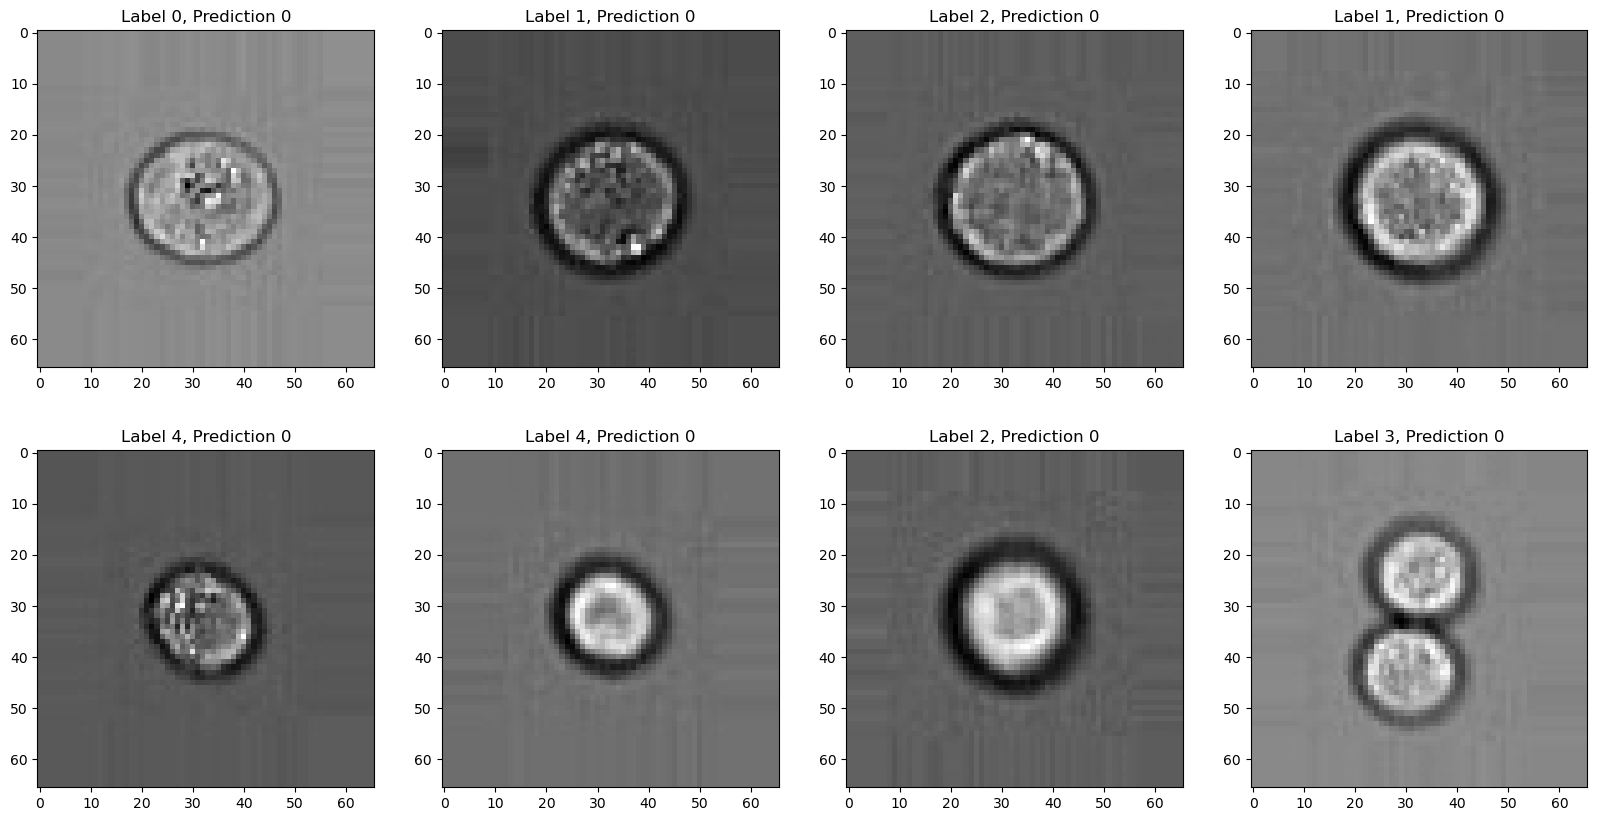

In [30]:
lc = LinearClassifier()

fig, axes = plt.subplots(2, 4, figsize=(20,10))
for i, j in enumerate(np.random.randint(X_test.shape[0], size=(8,))):
    
    # Get an example image
    X_sample = X_test[j,...]
    
    # Reshape flattened vector to image
    X_reshape = np.reshape(X_sample, (66, 66))
    
    # Predict the label
    y_pred = lc.predict(X_sample)
    
    # Display results
    axes.flatten()[i].imshow(X_reshape, cmap='gray')
    axes.flatten()[i].set_title('Label ' + str(np.argmax(y_test[j])) +', Prediction ' + str(np.argmax(y_pred)))

<div class="alert alert-block alert-info">

#### Task 2.1
What do you notice about the initial results of the model? 

</div>

The model exclusively predicts a class of 0. This result makes sense given that we initialized the model with weights of 0. 

## Stochastic gradient descent
To train this model, we will use stochastic gradient descent. In its simplest version, this algorithm consists of the following steps:
- Select several images from the training dataset at random
- Compute the gradient of the loss function with respect to the weights, given the selected images
- Update the weights using the update rule $\Delta W_{ij} \rightarrow \Delta W_{ij} - lr\frac{\partial loss}{\partial W_{ij}}$

Recall that the origin of this update rule is from multivariable calculus - the gradient tells us the direction in which the loss function increases the most. So to minimize the loss function we move in the opposite direction of the gradient.

Also recall from the course notes that for this problem we can compute the gradient analytically. The gradient is given by

\begin{equation}
\frac{\partial loss}{\partial W_{ij}} = \left(p_i - 1(i \mbox{ is correct}) \right)x_j,
\end{equation}
where $1$ is an indicator function that is 1 if the statement inside the parentheses is true and 0 if it is false.

A complete derivation of $\frac{\partial loss}{\partial W_{ij}}$ is included in the Towards Data Science [article](https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1) recommended above if you are interested in the details.

In [74]:
def grad(self, X, y_true, y_pred):
    # Compute the gradients for each class and save in list
    gradients = []
    for i in range(self.n_classes):
        # Calculate the difference between the class probability and true score
        difference = y_pred[..., i] - y_true[..., i]
        difference = np.expand_dims(difference, axis=-1)
        grad = difference * X
        gradients.append(grad)
    
    gradient = np.stack(gradients, axis=1)
    
    return gradient
    
def loss(self, X, y_true, y_pred):
    loss = np.mean(-y_true * np.log(y_pred))
    
    return loss
    
def fit(self, X_train, y_train, n_epochs, batch_size=1, learning_rate=1e-5):
    loss_list = []
    
    rng = np.random.default_rng()
    
    # Iterate over epochs
    for epoch in range(n_epochs):
        print(f'Epoch {epoch}')
        n_batches = int(np.floor(X_train.shape[0] / batch_size))
        
        # Generate random index
        index = np.arange(X_train.shape[0])
        np.random.shuffle(index)
        X_shfl = X_train[index]
        y_shfl = y_train[index]
        
        # Iterate over batches
        for batch in tqdm.trange(n_batches):
            beg = batch*batch_size
            end = (batch+1)*batch_size if (batch+1)*batch_size < X_train.shape[0] else -1
            X_batch = X_shfl[beg:end]
            y_batch = y_shfl[beg:end]
            
            # Skip empty batch if it shows up at the end of the epoch
            if X_batch.shape[0] == 0:
                continue
            
            # Predict
            y_pred = self.predict(X_batch)
            
            # Compute the loss
            loss = self.loss(X_batch, y_batch, y_pred)
            loss_list.append(loss)
            
            # Compute the gradient
            gradient = self.grad(X_batch, y_batch, y_pred)
            
            # Compute the mean gradient over all the example images
            gradient = np.mean(gradient, axis=0, keepdims=False)

            # Update the weights
            self.W -= learning_rate * gradient
            
            if np.count_nonzero(np.isnan(self.W)) != 0:
                print(epoch, batch)
                break
            
    return loss_list

# Assign methods to class
setattr(LinearClassifier, 'grad', grad)
setattr(LinearClassifier, 'loss', loss)
setattr(LinearClassifier, 'fit', fit)

We're ready to train our model!

In [75]:
%%time
lc = LinearClassifier()
loss = lc.fit(X_train, y_train, n_epochs=50, batch_size=16)

Epoch 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 910.35it/s]


Epoch 1


 48%|████████████████████████████████████████████████████▉                                                         | 2417/5028 [00:02<00:03, 852.89it/s]/var/folders/bd/bn434f8n1bsdd8y0yby_fv7r0000gn/T/ipykernel_20807/2509305538.py:16: RuntimeWarning: divide by zero encountered in log
  loss = np.mean(-y_true * np.log(y_pred))
/var/folders/bd/bn434f8n1bsdd8y0yby_fv7r0000gn/T/ipykernel_20807/2509305538.py:16: RuntimeWarning: invalid value encountered in multiply
  loss = np.mean(-y_true * np.log(y_pred))
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 907.77it/s]


Epoch 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 956.26it/s]


Epoch 3


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 920.27it/s]


Epoch 4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 919.23it/s]


Epoch 5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 940.72it/s]


Epoch 6


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 907.23it/s]


Epoch 7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 938.50it/s]


Epoch 8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 926.63it/s]


Epoch 9


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 902.57it/s]


Epoch 10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 924.72it/s]


Epoch 11


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 933.10it/s]


Epoch 12


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 910.78it/s]


Epoch 13


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 936.74it/s]


Epoch 14


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 938.46it/s]


Epoch 15


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 898.98it/s]


Epoch 16


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 956.84it/s]


Epoch 17


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 927.77it/s]


Epoch 18


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 918.23it/s]


Epoch 19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 907.97it/s]


Epoch 20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 900.08it/s]


Epoch 21


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 906.78it/s]


Epoch 22


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 896.18it/s]


Epoch 23


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 916.82it/s]


Epoch 24


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 969.54it/s]


Epoch 25


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 923.15it/s]


Epoch 26


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 915.16it/s]


Epoch 27


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 959.86it/s]


Epoch 28


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 947.36it/s]


Epoch 29


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 920.11it/s]


Epoch 30


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 897.78it/s]


Epoch 31


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 888.87it/s]


Epoch 32


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 921.23it/s]


Epoch 33


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 880.66it/s]


Epoch 34


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 918.89it/s]


Epoch 35


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 909.61it/s]


Epoch 36


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 959.11it/s]


Epoch 37


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 885.67it/s]


Epoch 38


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:06<00:00, 827.15it/s]


Epoch 39


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 915.76it/s]


Epoch 40


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 905.58it/s]


Epoch 41


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 922.83it/s]


Epoch 42


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 848.34it/s]


Epoch 43


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 856.56it/s]


Epoch 44


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 855.38it/s]


Epoch 45


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 874.54it/s]


Epoch 46


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 907.61it/s]


Epoch 47


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 862.25it/s]


Epoch 48


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 863.11it/s]


Epoch 49


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5028/5028 [00:05<00:00, 960.84it/s]

CPU times: user 34min 1s, sys: 2min 48s, total: 36min 50s
Wall time: 4min 38s


Let's plot the loss curve to see how the model trained.

In [90]:
def smooth(scalars, weight):
    """Compute the exponential moving average to smooth data
    
    Credit: https://stackoverflow.com/questions/42281844/what-is-the-mathematics-behind-the-smoothing-parameter-in-tensorboards-scalar/49357445#49357445
    
    """
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed

Text(0.5, 0, 'batch')

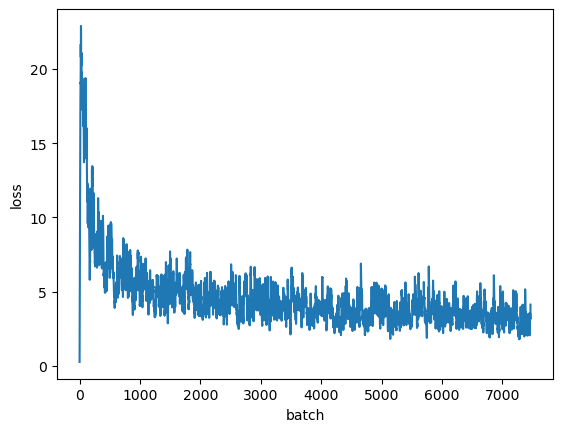

In [91]:
fig, ax = plt.subplots()
ax.plot(smooth(loss, 0.9))
ax.set_ylabel('loss')
ax.set_xlabel('batch')

## Evaluate the model

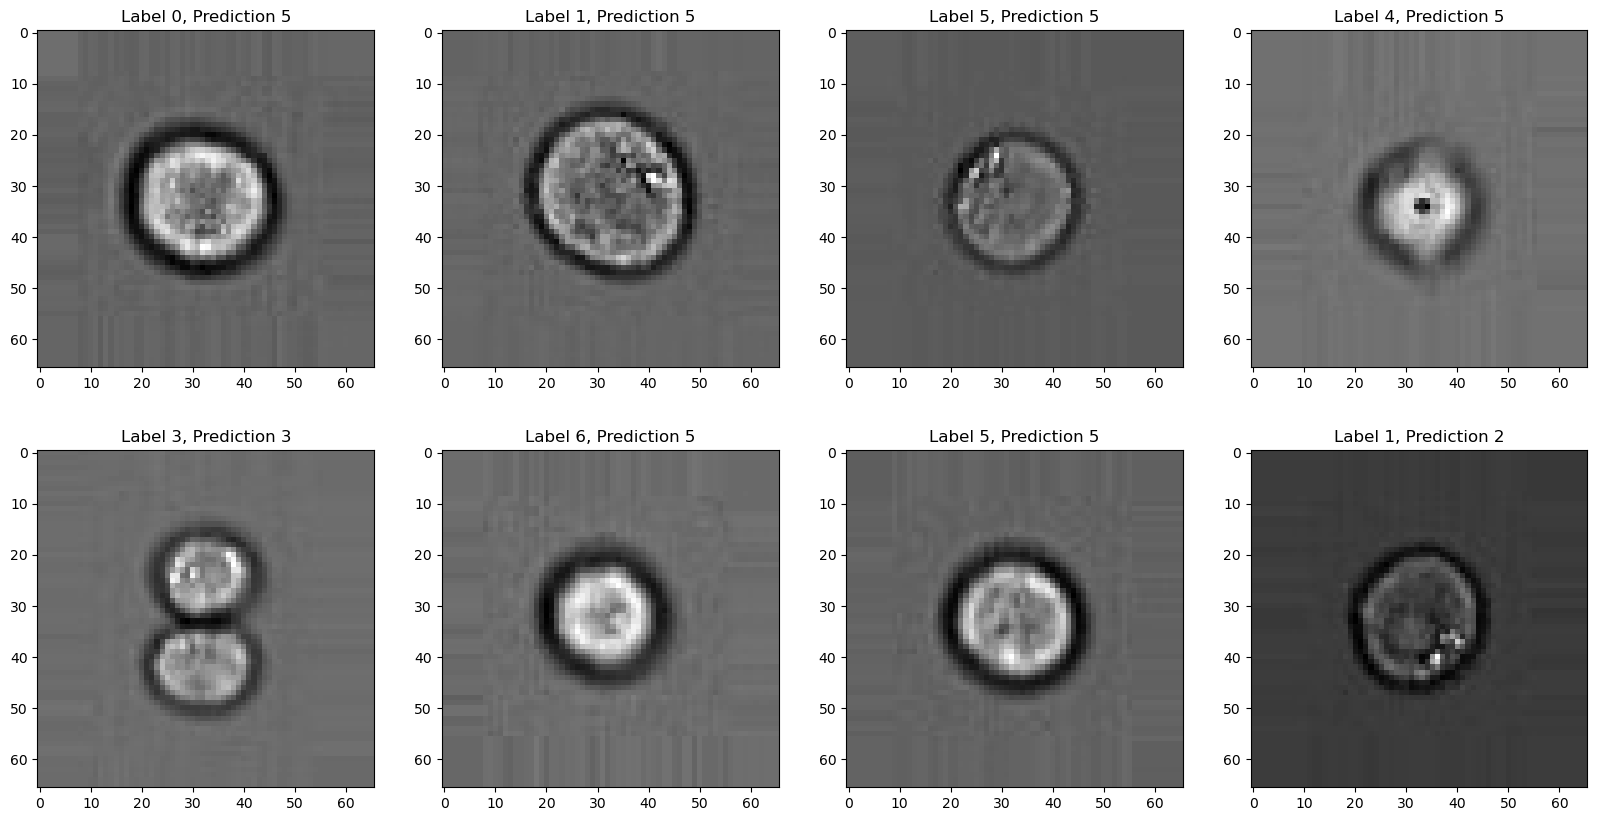

In [78]:
# Visualize some predictions

fig, axes = plt.subplots(2, 4, figsize=(20,10))
for i, j in enumerate(np.random.randint(X_test.shape[0], size=(8,))):
    
    # Get an example image
    X_sample = X_test[j]
    
    # Reshape flattened vector to image
    X_reshape = np.reshape(X_sample, (66, 66))
    
    # Predict the label
    y_pred = lc.predict(X_sample)
    
    # Display results
    axes.flatten()[i].imshow(X_reshape, cmap='gray')
    axes.flatten()[i].set_title('Label ' + str(np.argmax(y_test[j])) +', Prediction ' + str(np.argmax(y_pred)))

In addition to inspecting the results of individual predictions, we can also look at summary statistics that capture model performance.

In [43]:
def benchmark_performance(y_true, y_pred):
    """Calculates recall, precision, f1 and a confusion matrix for sample predictions
    
    Args:
        y_true (list): List of integers of true class values
        y_pred (list): List of integers of predicted class value
            
    Returns:
        dict: Dictionary with keys `recall`, `precision`, `f1`, and `cm`
    
    """
    _round = lambda x: round(x, 3)
    
    metrics = {
        'recall': _round(sklearn.metrics.recall_score(y_true, y_pred, average='macro')),
        'precision': _round(sklearn.metrics.precision_score(y_true, y_pred, average='macro')),
        'f1': _round(sklearn.metrics.f1_score(y_true, y_pred, average='macro')),
        'cm': sklearn.metrics.confusion_matrix(y_true, y_pred, normalize=None),
        'cm_norm': sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='true')
    }
    
    return metrics

<div class="alert alert-block alert-info">

#### Task 2.2

For each of the 4 metrics above, describe in your own words what this metric tells you about model performance.

- Recall
- Precision
- F1
- Confusion Matrix

</div>

- Recall -- Measures the ratio of true positives to the total positives that the model should have identified. Captures the ability of the model to find all positive samples. $$\frac{\texttt{true positive}}{\texttt{true positive} + \texttt{false negative}}$$
- Precision -- Measures the ratio of true positives to all positive predictions. Captures the ability of the model to accurately identify positive samples without misclassifying negative samples.
$$\frac{\texttt{true positive}}{\texttt{true positive} + \texttt{false positive}}$$
- F1 -- Summary statistic that captures both precision and recall
$$\frac{2*\texttt{precision}*\texttt{recall}}{\texttt{precision}+\texttt{recall}}$$
- Confusion Matrix -- Captures the exact failure modes of the model by contrasting predicted classes with true classes.

In [44]:
def plot_metrics(metrics, name, ax=None):
    """Plots a confusion matrix with summary statistics listed above the plot
    
    The annotations on the confusion matrix are the total counts while
    the colormap represents those counts normalized to the total true items
    in that class.
    
    Args:
        metrics (dict): Dictionary output of `benchmark_performance`
        name (str): Title for the plot
        ax (optional, matplotlib subplot): Subplot axis to plot onto. 
            If not provided, a new plot is created
        classes (optional, list): A list of the classes to label the X and y 
            axes. Defaults to [0, 1] for a two class problem.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,5))
    cb = ax.imshow(metrics['cm_norm'], cmap='Greens', vmin=0, vmax=1)
    
    classes = np.arange(metrics['cm'].shape[0])
    plt.xticks(range(len(classes)), class_lut)
    plt.yticks(range(len(classes)), class_lut)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

    for i in range(len(classes)):
        for j in range(len(classes)):
            color='green' if metrics['cm_norm'][i,j] < 0.5 else 'white'
            ax.annotate('{}'.format(metrics['cm'][i,j]), (j, i),
                        color=color, va='center', ha='center')

    _ = plt.colorbar(cb, ax=ax)
    _ = ax.set_title(
            '{}\n'\
            'Recall: {}\n'\
            'Precision: {}\n'\
            'F1 Score: {}\n'\
            ''.format(name, metrics['recall'], metrics['precision'], metrics['f1'])
        )

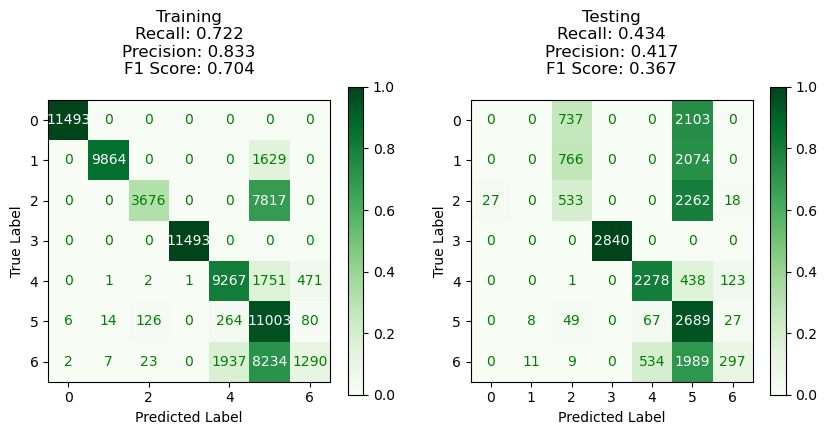

In [79]:
# Generate predictions and metrics for training data
y_pred = lc.predict(X_train)
# Convert from one hot encoding to original class labels
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_train, axis=-1)
lc_train_metrics = benchmark_performance(y_true, y_pred)

# Generate predictions and metrics for test data
y_pred = lc.predict(X_test)
# Convert from one hot encoding to original class labels
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test, axis=-1)
lc_test_metrics = benchmark_performance(y_true, y_pred)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

plot_metrics(lc_train_metrics, 'Linear Classifier Training', ax[0])
plot_metrics(lc_test_metrics, 'Linear Classifier Testing', ax[1])

<div class="alert alert-block alert-info">
    
#### Task 2.3

What do you notice about the results after training the model?
    
</div>

<div class="alert alert-block alert-success">
    
## Checkpoint 2
    
We have written a simple linear classifier, trained it and considered a few ways to evaluate model performance. Next we'll look at some other machine learning methods for classification.
    
</div>

![](https://miro.medium.com/v2/resize:fit:1262/format:webp/1*LMoJmXCsQlciGTEyoSN39g.jpeg)

![](https://miro.medium.com/v2/resize:fit:1052/format:webp/1*VHDtVaDPNepRglIAv72BFg.jpeg)

# Part B: Random Forest Classifier 

Decisions trees are a useful tool for generating interpretable classification results. As shown in the example below, trees are constructed such that the data is split at each node according to a feature in the data. At the bottom of the tree, the leafs should correspond to a single class such that we can predict the class of the data depending on which leaf it is associated with.

![](https://miro.medium.com/v2/resize:fit:1262/format:webp/1*LMoJmXCsQlciGTEyoSN39g.jpeg)

(*Image by [Tony Yiu](https://towardsdatascience.com/understanding-random-forest-58381e0602d2)*)

A random forest classifer is much like what it sounds. It takes predictions from many different decision trees and assigns the class with the most votes. Ultimately this ensemble method of considering many different trees performs better than any one decision tree.

![](https://miro.medium.com/v2/resize:fit:1052/format:webp/1*VHDtVaDPNepRglIAv72BFg.jpeg)

(*Image by [Tony Yiu](https://towardsdatascience.com/understanding-random-forest-58381e0602d2)*)

In this exercise, we wi
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [97]:
%%time
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

CPU times: user 2min 48s, sys: 598 ms, total: 2min 48s
Wall time: 2min 48s


RandomForestClassifier()

/Users/morganschwartz/mambaforge/envs/01_intro_ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


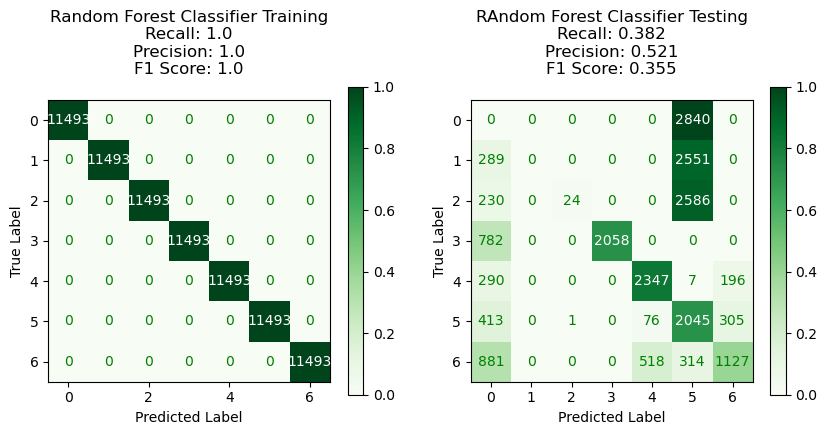

In [98]:
# Generate predictions and metrics for training data
y_pred = rfc.predict(X_train)
# Convert from one hot encoding to original class labels
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_train, axis=-1)
rfc_train_metrics = benchmark_performance(y_true, y_pred)

# Generate predictions and metrics for test data
y_pred = rfc.predict(X_test)
# Convert from one hot encoding to original class labels
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test, axis=-1)
rfc_test_metrics = benchmark_performance(y_true, y_pred)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

plot_metrics(rfc_train_metrics, 'Random Forest Classifier Training', ax[0])
plot_metrics(rfc_test_metrics, 'Random Forest Classifier Testing', ax[1])

## Parameter Optimization

Our initial random forest classifier was trained using the default parameters provided by `sklearn`, but these often won't be the right values for our problem. In many situations, we may have some idea what a reasonable parameter value might be, but most of the time we will need to perform a grid search to select the optimal value. `sklearn` provides a class `RandomizedSearchCV` ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)) to perform a random search over a provided grid of parameters, which we can use to improve the performance of the random forest classifier. 

<div class="alert alert-block alert-info">
    
#### Task 3.1

For this task, your job is to select a set of parameters to use for optimization. You should start by looking at the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for `RandomForestClassifier` to see what parameters are available. For each parameter that you choose to optimize, think about what range of values you should try. 

For example:    
```
parameter_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [1, 2, 3]
}
```

Fill out the dictionary below with your parameter selection.
    
</div>

In [99]:
##########################
######## To Do ###########
##########################

parameter_grid = {}

In [106]:
##########################
####### Solution #########
##########################

parameter_grid = {
    'n_estimators': np.linspace(100, 2000, 10, dtype=int),
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [1, 5, 10, 20, 50, 75, 100, 150, 200],
    'min_samples_split': [2, 5, 10, 15, 20, 30],
    'min_samples_leaf': [1, 2, 3, 4],
    'bootstrap': [True, False]
}

If we had more time, we could use `RandomizedSearchCV` to look for the best set of parameters:

```python
rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=parameter_grid,
    n_iter=5,
    verbose=3)
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)
```

However to save on time we are going to distribute the work among the group. 

<div class="alert alert-block alert-success">
    
## Checkpoint 3
    
We'll come back together as a group to discuss the parameter space that we want to explore and to sign up for parameter configurations.
    
</div>

<div class="alert alert-block alert-info">
    
#### Task 4.1

Configure the `RandomForestClassifier` below with a set of parameters according to the parameter space we discussed during the previous checkpoint. Then train and evaluate your classifier!
    
</div>

In [97]:
##########################
######## To Do ###########
##########################

random_rf = RandomForestClassifier(
    # Add your parameter configuration here
)

In [97]:
%%time
random_rfc.fit(X_train, y_train)

# Generate predictions and metrics for training data
y_pred = random_rfc.predict(X_train)
# Convert from one hot encoding to original class labels
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_train, axis=-1)
rfc_train_metrics = benchmark_performance(y_true, y_pred)

# Generate predictions and metrics for test data
y_pred = random_rfc.predict(X_test)
# Convert from one hot encoding to original class labels
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test, axis=-1)
rfc_test_metrics = benchmark_performance(y_true, y_pred)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

plot_metrics(rfc_train_metrics, 'Random Forest Classifier Training', ax[0])
plot_metrics(rfc_test_metrics, 'Random Forest Classifier Testing', ax[1])

CPU times: user 2min 48s, sys: 598 ms, total: 2min 48s
Wall time: 2min 48s


RandomForestClassifier()

<div class="alert alert-block alert-success">
    
## Checkpoint 4
    
Report the performance of your model on the test split in the group spreadsheet (check Element for a link). We'll discuss what seems to be working best as a group.
    
</div>

# Part C: Feature Engineering

Classical machine learning methods often turn to manual feature engineering to extract elements of the data that the model will use for prediction. So far we have relied on the raw data alone, but in some cases well designed features can produce a better model than raw data alone.

## Introduction to image filters

Image filters operate by taking a small kernel (or matrix) and applying it to each pixel in the image to compute a new value. As an example, this is the identity kernel 
$$
\begin{bmatrix}
    0 & 0 & 0 \\
    0 & 1 & 0 \\
    0 & 0 & 0 \\
\end{bmatrix}
$$
which when applied to an image will not result in any changes to the data.

Filters can produce a variety of effects on images depending on how the kernel is configured. This can range from blurring an image to extracting edges. Filtered images can contain data that is more informative to the model when distinguishing between classes.

In [ ]:
im = X[np.random.randint(X.shape[0]),...,0]
fig, ax = plt.subplots(1, 3, figsize=(10, 4))

ax[0].imshow(im)
ax[0].set_title('Original')

ax[1].imshow(skimage.filters.gaussian(im))
ax[1].set_title('Gaussian')

ax[2].imshow(skimage.filters.laplace(im))
ax[2].set_title('Laplace')

A variety of filters are made available through the `skimage.filters` [module](https://scikit-image.org/docs/stable/api/skimage.filters.html). In this part of the exercise, we are going to explore how filters can be applied to images in order to extract features for model prediction. While we are going to work with the filters that are easily available through skimage, there are many other transformations that can be applied to images.

In [ ]:
from inspect import getmembers, isfunction

# List all functions in the skimage.filters module to get a list of available filters
[m[0] for m in getmembers(skimage.filters, isfunction)]

<div class="alert alert-block alert-info">

#### Task 3.1

Test a variety of the available filters from the `skimage` module. Whenever you are making a modification to an image, you should check the results to make sure that errors are not introduced while generating the transformation. The easiest way to plot an image is just to run `plt.imshow(image)`.

Ultimately we are going to use model performance to select the best features for our classification task, but you should be familiar with the output of any filters that you are using. The goal of this next section is to identify a set of candidate filters from which one will be chosen that you think will lead to better classification results on the two classes we are trying to distinguish.

Keep the following things you may want to keep in mind as you approach this problem
- Look at several randomly selected images from the two classes when you are testing a filter
- Explore the effect of parameters available for each filter

**Challenge**: While this task could be approached by testing filters one at a time, consider writing a for loop to rapidly test filters in an automated fashion.


**Tip**: Within a jupyter notebook, you can run `function?` to look at the documentation for that function. Check out the example below.

</div>

In [ ]:
skimage.filters.gaussian?

In [ ]:
##########################
######## To Do ###########
##########################

# Put your code for testing filters here

In [ ]:
filters = {
    'butterworth': skimage.filters.butterworth,
    # We can use a lambda function to configure this function with default parameters of 2 and 10
    'difference_of_gaussians': lambda im: skimage.filters.difference_of_gaussians(im, low_sigma=2, high_sigma=10),
    'farid': skimage.filters.farid,
    'farid_h': skimage.filters.farid_h,
    'farid_v': skimage.filters.farid_v,
    'frangi': skimage.filters.frangi,
    'gaussian': skimage.filters.gaussian,
    'hessian': skimage.filters.hessian,
    'laplace': skimage.filters.laplace,
    'median': skimage.filters.median,
    'meijering': skimage.filters.meijering,
    'prewitt': skimage.filters.prewitt,
    'prewitt_h': skimage.filters.prewitt_h,
    'prewitt_v': skimage.filters.prewitt_v,
    'roberts': skimage.filters.roberts,
    'roberts_neg_diag': skimage.filters.roberts_neg_diag,
    'roberts_pos_diag': skimage.filters.roberts_pos_diag,
    'sato': skimage.filters.sato,
    'scharr': skimage.filters.scharr,
    'scharr_h': skimage.filters.scharr_h,
    'scharr_v': skimage.filters.scharr_v,
    'sobel': skimage.filters.sobel,
    'sobel_h': skimage.filters.sobel_h,
    'sobel_v': skimage.filters.sobel_v,
    'unsharp_mask': skimage.filters.unsharp_mask,
}

First we will try applying each filter to a sample image. By setting up the for loop with a try/except block, we can catch any errors that appear and correct them in a second iteration.

In [ ]:
# Select random image
im = X[np.random.randint(X.shape[0]),...,0]

# Plot original image
fig, ax = plt.subplots(figsize=(3, 3))
plt.imshow(im)
ax.set_title('Original')

# Plot filtered images
fig, ax = plt.subplots(5, 5, figsize=(20, 20))
for i, (name, fxn) in enumerate(filters.items()):
    ax.flatten()[i].set_title(name)
    try:
        ax.flatten()[i].imshow(fxn(im))
    except Exception as e:
        print('Skipping {}: {}'.format(name, e))

Now we'll look at how different parameters can change the effect of some of these filters.

In [ ]:
n_params = 3

filter_params = [
    {
        'function': skimage.filters.gaussian,
        'sigma': [1, 2, 5]
    },
    {
        'function': skimage.filters.difference_of_gaussians,
        'low_sigma': [1, 2, 5],
        'high_sigma': [2, 5, 10]
    },
    {
        'function': skimage.filters.laplace,
        'ksize': [3, 10, 20]
    }
]

In [ ]:
# Select random image
im = X[np.random.randint(X.shape[0]),...,0]

# Plot original image
fig, ax = plt.subplots(figsize=(3, 3))
plt.imshow(im)
ax.set_title('Original')

# Plot filtered images
for config in filter_params:
    fig, ax = plt.subplots(1, n_params, figsize=(10, 3))
    ax[0].set_ylabel(config['function'].__name__)
    
    for i in range(n_params):
        # Construct kwargs for each case
        kwargs = {}
        for k, v in config.items():
            if k == 'function': 
                continue
            else:
                kwargs[k] = v[i]
        
        # Plot filtered image
        ax[i].imshow(config['function'](im, **kwargs))
        ax[i].set_title(str(kwargs))
    

Let's look at three candidate filters on several images from each class.

In [ ]:
candidates = {
    'original': lambda im: im,
    'difference_of_gaussians': lambda im: skimage.filters.difference_of_gaussians(im, low_sigma=1, high_sigma=2),
    'farid': skimage.filters.farid,
    'frangi': skimage.filters.frangi
}

In [ ]:
nsamples = 3

# Take a random sampling from each class
idxs, classes = [], []
for c in [0, 1]:
    xx = X[y == c]
    samples = np.random.randint(xx.shape[0], size=(nsamples,))
    idxs.extend(samples)
    classes.extend([c] * nsamples)
    
for name, fxn in candidates.items():
    fig, ax = plt.subplots(1, nsamples * 2, figsize=(20, 5))
    ax[0].set_ylabel(name)
    
    for i, (c, idx) in enumerate(zip(classes, idxs)):
        ax[i].imshow(fxn(X[idx, ..., 0]))
        ax[i].set_title(c)

<div class="alert alert-block alert-success">
    
## Checkpoint ?
    
Please 👍 the "Checkpoint 2" slack thread when you reach this checkpoint.

We'll discuss as a group which filters seem like they may be most effective at distinguishing our two classes. Please be prepared with your top two or three candidates. 

*Bonus:* Collect screenshots of your filtering results to share with the group. Look out for a slack message for instructions on how to submit images.
    
</div>

<div class="alert alert-block alert-info">

## Task ??
    
    todo need to rewrite
    
Starting with a few of your top choices for filters, train a model on each filter variation and compare the results. Again as an extra challenge, you can write a for loop to automate this process.

You will roughly need to follow these steps:
- Create a new version of `X` and `y` with the filter applied. Make sure that you are working on a new copy of the original data each time you apply a filter. You can use `copy.deepcopy` to create a new copy of an array.
- Create a new `DatasetBuilder` object with the filtered images
    ```
    with tf.device('CPU:0'):
        dataset = build_dataset(X, y, batch_size=64, seed=seed, train_size=train_size)
    ```
- Train a model using the functions `create_linear_classifier` and `train_model` that are defined in an earlier section of the notebook
- Benchmark and collect the metrics for each model variant 
</div>

<div class="alert alert-block alert-success">
    
## Checkpoint
    
    todo
    
Please 👍 the "Checkpoint 2" slack thread when you reach this checkpoint.

We'll discuss as a group what filters worked best to distinguish between the two classes. When you're ready, you can submit your best model to this [google form](https://docs.google.com/forms/d/e/1FAIpQLSfVblJCnprXct0IrS87cGw4ijpH2h6bKvcXqj7RNraMrSP3PA/viewform?usp=sf_link). 
    
</div>

## Bonus

If you have extra time, try one of the following challenges:
- How does your selected filter perform on another pair of classes in this dataset?
- Can you automate the search for the top performing filter by writing a function that ultimately reports the top performer?